*En este cuaderno se resuelve un problema de clasificación binaria de sentimiento a partir de datos de reviews de películas. Se utilizarán embeddings para obtener una representación vectorial de los datos donde palabras similares se mantengan en zonas cercanas de la representación interna del modelo (espacio latente).*

## Carga de datos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pip install tensorflow-hub
# pip install tensorflow-datasets
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [ ]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Cada ejemplo es una frase que representa la crítica de la película y una etiqueta correspondiente (0 si es una reseña negativa y 1 si es una reseña positiva)

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Entrenamiento del modelo

En lugar de aprender el embedding desde cero, podemos utilizar un embedding ya pre-entrenado, lo cual permite:



*   No preocuparse del preprocesamiento del texto (no tokenization, normalization, one-hot encoding...)
*   Aprovechar el aprendizaje de un modelo ya entrenado (Transfer Learning)

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/10
30/30 [==============================] - 3s 70ms/step - loss: 0.6488 - accuracy: 0.5393 - val_loss: 0.6033 - val_accuracy: 0.6058
Epoch 2/10
30/30 [==============================] - 2s 53ms/step - loss: 0.5391 - accuracy: 0.6846 - val_loss: 0.4934 - val_accuracy: 0.7526
Epoch 3/10
30/30 [==============================] - 2s 53ms/step - loss: 0.4040 - accuracy: 0.8222 - val_loss: 0.3947 - val_accuracy: 0.8176
Epoch 4/10
30/30 [==============================] - 2s 52ms/step - loss: 0.2885 - accuracy: 0.8879 - val_loss: 0.3398 - val_accuracy: 0.8519
Epoch 5/10
30/30 [==============================] - 2s 52ms/step - loss: 0.2095 - accuracy: 0.9263 - val_loss: 0.3138 - val_accuracy: 0.8637
Epoch 6/10
30/30 [==============================] - 2s 52ms/step - loss: 0.1536 - accuracy: 0.9506 - val_loss: 0.3052 - val_accuracy: 0.8655
Epoch 7/10
30/30 [==============================] - 2s 52ms/step - loss: 0.1124 - accuracy: 0.9680 - val_loss: 0.3045 - val_accuracy: 0.8718
Epoch 8/10
30

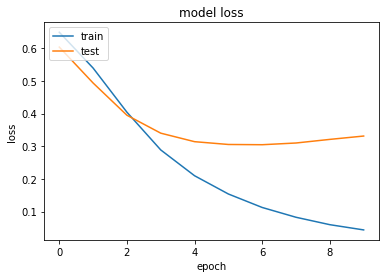

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_data.batch(512), verbose=2)

49/49 - 1s - loss: 0.3614 - accuracy: 0.8520 - 959ms/epoch - 20ms/step


## Predicciones

In [ ]:
predictions = model.predict(test_data.batch(512))

49/49 [==============================] - 1s 20ms/step


In [ ]:
 # cambiar para ver las predicciones para distintas reviews
sentence_index = 2
sentence = next(iter(train_data.batch(10)))[0][sentence_index]
sentence

<tf.Tensor: shape=(), dtype=string, numpy=b'Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Mountie telling the people of Dawson City, Yukon to elect themselves a marshal (yes a marshal!) and to enforce the law themselves, then gunfighters battling it out on the streets for control of the town? <br /><br />Nothing even remotely resembling that happened on the Canadian side of the border during the Klondike gold rush. Mr. Mann and company appear to have mistaken Dawson City for Deadwood, the Canadian North for the American Wild West.<br /><br />Canadian viewers be prepared for a Reefer Madness type of enjoyable howl with this ludicrous plot, or, to shake your head in disgust.'>

In [ ]:
preds_sentence = "Positive" if predictions[sentence_index] == 1 else "Negative"
print("\nPrediction:", preds_sentence)


Prediction: Negative
